In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
import os
import cv2
import numpy as np
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD

In [ ]:
model = VGG16(include_top=False, input_shape=(150, 150, 3))

In [ ]:
flat1 = Flatten()(model.layers[-1].output) # flatten last layer
class1 = Dense(1024, activation='relu')(flat1) # add FC layer on previous layer
output = Dense(6, activation='softmax')(class1) # add softmax layer

In [ ]:
model = Model(inputs=model.inputs, outputs=output)
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

In [ ]:
train_dir ='/content/drive/MyDrive/data/seg_train'
valid_dir ='/content/drive/MyDrive/data/seg_test/'
pred_dir  = '/content/drive/MyDrive/data/seg_pred/'

In [ ]:
#Add data-augmentation parameters to ImageDataGenerator
datagen = ImageDataGenerator(rescale = 1./255)

#Generate batches and load data with real-time data augmentation.
train_generator=datagen.flow_from_directory(
      train_dir,
      target_size=(150,150),
      batch_size=64,
      class_mode='categorical')
validation_generator=datagen.flow_from_directory(
      valid_dir,
      target_size=(150,150),
      batch_size=64,
      class_mode='categorical')
test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(
    pred_dir, 
    target_size=(150,150),
    batch_size=32,
    class_mode = 'categorical' ) 

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 7301 images belonging to 6 classes.


In [ ]:
#Compile the model
sgd = SGD(lr=0.001, decay=1e-7, momentum=.9)
model.compile(loss='categorical_crossentropy', 
              optimizer=sgd,
              metrics=['accuracy'])

In [ ]:
H = model.fit(train_generator, batch_size=64,
              epochs=10, 
              validation_data=validation_generator)

Epoch 1/10
220/220 [==============================] - 151s 682ms/step - loss: 0.8777 - accuracy: 0.6571 - val_loss: 0.3508 - val_accuracy: 0.8713
Epoch 2/10
220/220 [==============================] - 149s 677ms/step - loss: 0.3251 - accuracy: 0.8840 - val_loss: 0.2804 - val_accuracy: 0.8980
Epoch 3/10
220/220 [==============================] - 150s 680ms/step - loss: 0.2551 - accuracy: 0.9100 - val_loss: 0.2495 - val_accuracy: 0.9073
Epoch 4/10
220/220 [==============================] - 149s 676ms/step - loss: 0.2309 - accuracy: 0.9172 - val_loss: 0.2583 - val_accuracy: 0.9070
Epoch 5/10
220/220 [==============================] - 149s 675ms/step - loss: 0.2078 - accuracy: 0.9225 - val_loss: 0.2477 - val_accuracy: 0.9053
Epoch 6/10
220/220 [==============================] - 148s 672ms/step - loss: 0.1817 - accuracy: 0.9381 - val_loss: 0.2410 - val_accuracy: 0.9070
Epoch 7/10
220/220 [==============================] - 148s 673ms/step - loss: 0.1675 - accuracy: 0.9390 - val_loss: 0.2332 -

In [ ]:
# save the model's trained weights
model.save_weights('vgg_transfer_trained_wts.h5')

In [ ]:
score = model.evaluate(test_generator)
print('Test Loss = ', score[0])
print('Test Accuracy = ', score[1])

229/229 [==============================] - 18s 72ms/step - loss: 0.3865 - accuracy: 0.9011
Test Loss =  0.3865315020084381
Test Accuracy =  0.9011094570159912


In [ ]:
# Making prediction
y_pred = model.predict(test_generator)
y_true = np.argmax(y_pred, axis=-1)

#Confussion Matrix 
from sklearn.metrics import confusion_matrix
confusion_mtx = confusion_matrix(y_true, np.argmax(y_pred, axis=1))
confusion_mtx

array([[1074,    0,    0,    0,    0,    0],
       [   0, 1173,    0,    0,    0,    0],
       [   0,    0, 1307,    0,    0,    0],
       [   0,    0,    0, 1198,    0,    0],
       [   0,    0,    0,    0, 1250,    0],
       [   0,    0,    0,    0,    0, 1299]])

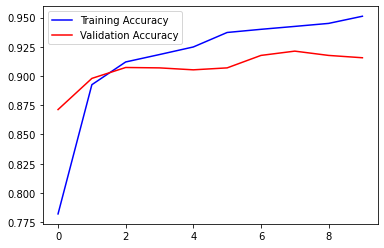

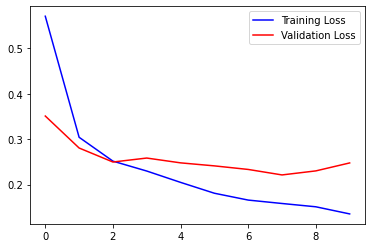

In [ ]:
#Plot training and validation accuracy 
acc=H.history['accuracy']
val_acc=H.history['val_accuracy']
loss=H.history['loss']
val_loss=H.history['val_loss']
epochs=range(len(acc)) 
 
import matplotlib.pyplot as plt
plt.plot(epochs,acc,'b',label='Training Accuracy')
plt.plot(epochs,val_acc,'r',label='Validation Accuracy')
plt.legend()
plt.figure()
 
#Plot training and validation loss 
plt.plot(epochs,loss,'b',label='Training Loss')
plt.plot(epochs,val_loss,'r',label='Validation Loss')
plt.legend()
plt.show()